# Object Detection and OCR Evaluation Pipeline
This notebook demonstrates a complete pipeline for object detection using YOLOv5 and Optical Character Recognition (OCR) using EasyOCR. The steps include performing object detection, cropping detected objects, applying OCR, and evaluating the OCR results.

## 1. Setting Up the Environment
We start by importing the necessary libraries, including YOLOv5 for object detection, EasyOCR for OCR, OpenCV for image processing, and Pandas for data manipulation.

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import torch
import os
import yaml
import cv2
import json
import pandas as pd
import random
import easyocr
import cv2
import matplotlib.pyplot as plt

We define the directories for the YOLOv5 model weights, dataset, and output locations.

In [2]:
project_dir = os.path.dirname(os.getcwd())
yolo_location = os.path.join(project_dir, 'yolov5')
dataset_location = os.path.join(project_dir, 'data', 'ocr_evaluation')
weights_location = os.path.join(project_dir, 'yoloV5_model_weights')

output_location = os.path.join(project_dir, 'data', 'yolo_v5')
output_name = 'detection_results'

## 2. Performing Object Detection


We run the YOLOv5 detection script to detect objects in the dataset images. The results are saved in the specified output directory.

In [3]:
%cd {yolo_location}
!python detect.py --weights {weights_location}/best.pt --img 416 --conf 0.4 --source {dataset_location} --save-txt --save-conf --project {output_location} --name {output_name}

/home/roma/5sem/Real-time_Number_Plate_Recognition/yolov5


/home/roma/5sem/Real-time_Number_Plate_Recognition/.venv/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


detect: weights=['/home/roma/5sem/Real-time_Number_Plate_Recognition/yoloV5_model_weights/best.pt'], source=/home/roma/5sem/Real-time_Number_Plate_Recognition/data/ocr_evaluation, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/home/roma/5sem/Real-time_Number_Plate_Recognition/data/yolo_v5, name=detection_results, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 2024-10-21 Python-3.12.7 torch-2.5.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 5834MiB)

Fusing layers... 
YOLOv5s_custom summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/395 /home/roma/5sem/Real-time_Number_Plate_Recognition/data/ocr_evaluation/00000.jpg: 320x416 1 License_Plate, 35.9ms


We iterate over the detected objects, crop them from the source images, and save the cropped images.

In [4]:
input_img_dir = dataset_location
input_txt_dir = f"{output_location}/{output_name}/labels"
output_dir = f'{output_location}/cropped_plates'
os.makedirs(output_dir, exist_ok=True)

for img_file in os.listdir(input_img_dir):
    if img_file.endswith('jpg'):
        img_path = os.path.join(input_img_dir, img_file)
        img = cv2.imread(img_path)
        img_height, img_width = img.shape[:2]

        txt_path = os.path.join(input_txt_dir, img_file[:-3]+'txt')
        try:
            with open(txt_path, 'r') as f:
                max_conf = -1.0
                for line in f.readlines():
                    class_id, x_center, y_center, width, height, conf = map(float, line.split())
                    x_center *= img_width
                    y_center *= img_height
                    width *= img_width
                    height *= img_height

                    x1 = int(x_center - width / 2)
                    y1 = int(y_center - height / 2)
                    x2 = int(x_center + width / 2)
                    y2 = int(y_center + height / 2)
                    cropped_plate = img[y1:y2, x1:x2]

                    # save plate with the highest confidence
                    if conf > max_conf:
                        plate_save_path = os.path.join(output_dir, f'plate_{img_file}')
                        cv2.imwrite(plate_save_path, cropped_plate)
                        max_conf = conf
        except FileNotFoundError:
            print(f"File not found: {txt_path}")

File not found: /home/roma/5sem/Real-time_Number_Plate_Recognition/data/yolo_v5/detection_results/labels/00591.txt
File not found: /home/roma/5sem/Real-time_Number_Plate_Recognition/data/yolo_v5/detection_results/labels/01026.txt
File not found: /home/roma/5sem/Real-time_Number_Plate_Recognition/data/yolo_v5/detection_results/labels/01803.txt
File not found: /home/roma/5sem/Real-time_Number_Plate_Recognition/data/yolo_v5/detection_results/labels/01003.txt
File not found: /home/roma/5sem/Real-time_Number_Plate_Recognition/data/yolo_v5/detection_results/labels/00440.txt
File not found: /home/roma/5sem/Real-time_Number_Plate_Recognition/data/yolo_v5/detection_results/labels/01595.txt
File not found: /home/roma/5sem/Real-time_Number_Plate_Recognition/data/yolo_v5/detection_results/labels/00573.txt
File not found: /home/roma/5sem/Real-time_Number_Plate_Recognition/data/yolo_v5/detection_results/labels/00741.txt
File not found: /home/roma/5sem/Real-time_Number_Plate_Recognition/data/yolo_v5/

## 3. Performing OCR on Cropped Images
We initialize the EasyOCR reader with English as the language.

In [5]:
reader = easyocr.Reader(['en'])

We iterate over the cropped images, apply preprocessing steps (scaling and Gaussian blur), and save the processed images. We then apply OCR to the processed images and save the OCR results in JSON files.

In [6]:
source_dataset_location = dataset_location
cropped_dataset_location = output_dir
results_dir = f"{output_location}/ocr_results"
scale_dataset_location = f"{output_location}/scaled_plates"
cropped_dataset_location

'/home/roma/5sem/Real-time_Number_Plate_Recognition/data/yolo_v5/cropped_plates'

In [7]:
os.makedirs(results_dir, exist_ok=True)
os.makedirs(scale_dataset_location, exist_ok=True)

for img_file in os.listdir(cropped_dataset_location):
    if img_file.endswith('jpg'):
        img_path = os.path.join(cropped_dataset_location, img_file)

        img = cv2.imread(img_path)

        scale_factor = 2
        img = cv2.resize(img, (0, 0), fx=scale_factor, fy=scale_factor)
        img = cv2.GaussianBlur(img,(5,5),0)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        output_path = os.path.join(scale_dataset_location, img_file)
        cv2.imwrite(output_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

        result = reader.readtext(output_path)
    
        output_txt_path = os.path.join(results_dir, img_file[:-3]+'json')
        with open(output_txt_path, 'w') as f:
            dict_lst = []
            for (bbox, text, prob) in result:
                dict_lst.append({'Text' : text, 'Probability' : prob})
            json.dump(dict_lst, f)


We display a random set of source and cropped images along with their OCR results.

{'Text': 'IJC', 'Probability': 0.9904802284648289}
{'Text': '774', 'Probability': 0.992289273558069}


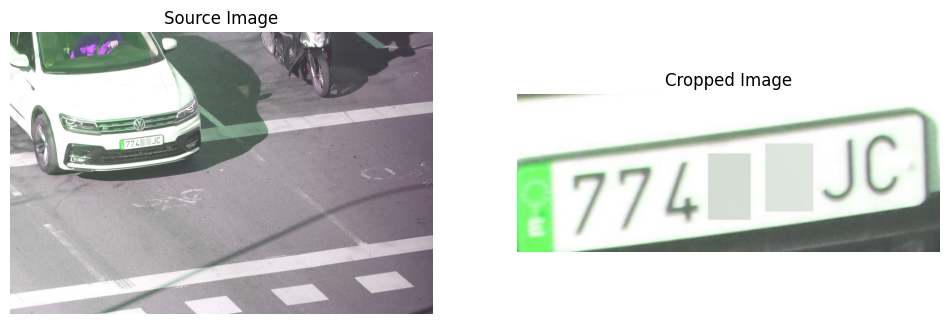

{'Text': 'SN', 'Probability': 0.9997625529131584}
{'Text': '018', 'Probability': 0.9979939371810375}


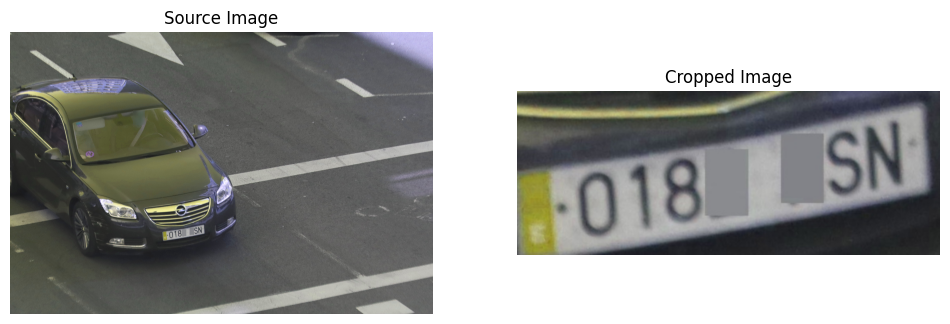

{'Text': '98 0', 'Probability': 0.5052810311317444}
{'Text': 'Cy', 'Probability': 0.37739260055381596}


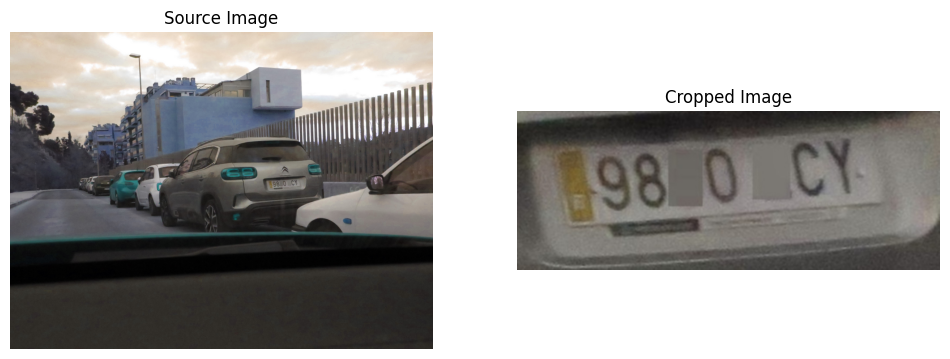

{'Text': '8', 'Probability': 0.99952941709995}
{'Text': 'RX', 'Probability': 0.9999420907212647}
{'Text': '75', 'Probability': 0.9999380572931587}


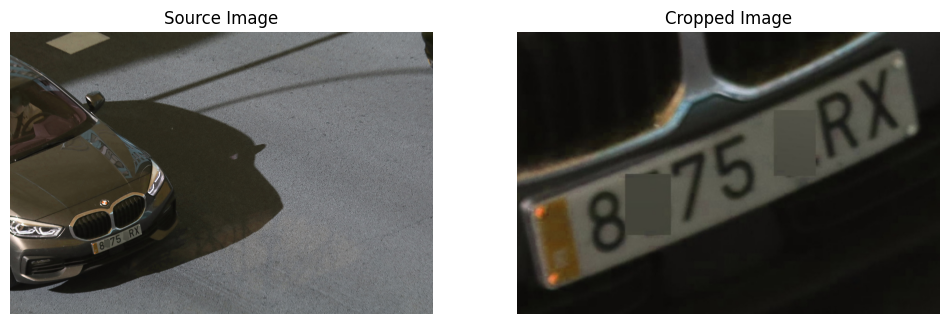

{'Text': 'E', 'Probability': 0.6720201791372951}
{'Text': '904', 'Probability': 0.9923328757286072}
{'Text': 'TP', 'Probability': 0.9990771930708555}


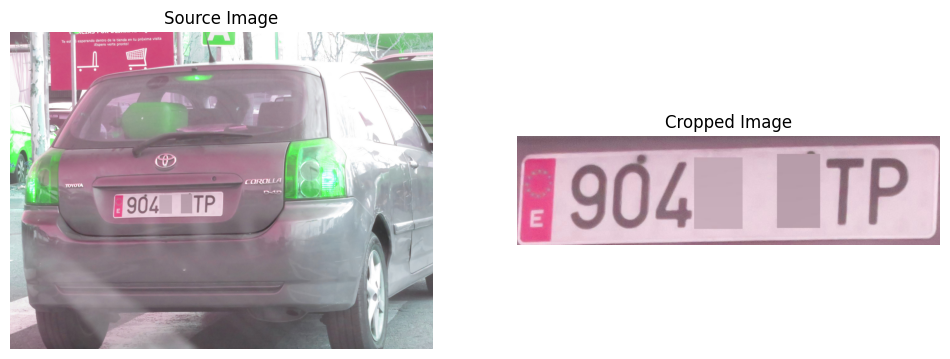

{'Text': 'L94', 'Probability': 0.6336712599921457}
{'Text': 'MP', 'Probability': 0.8091980166523284}


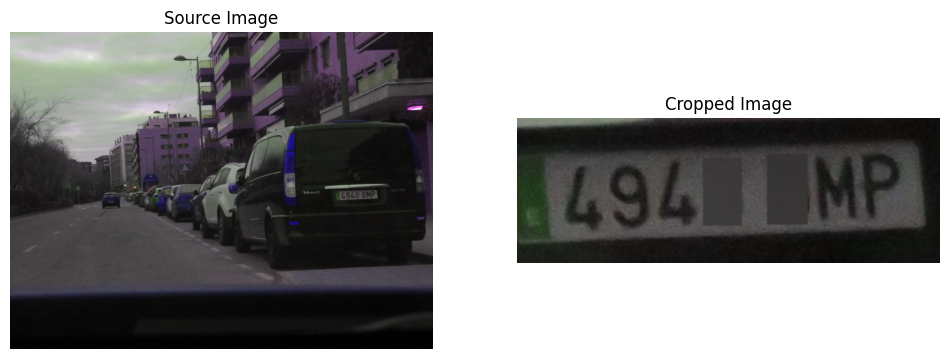

{'Text': '36', 'Probability': 0.9999941837398596}
{'Text': 'KZ', 'Probability': 0.498704409356575}
{'Text': 'Iimotorom', 'Probability': 0.4349775417450982}


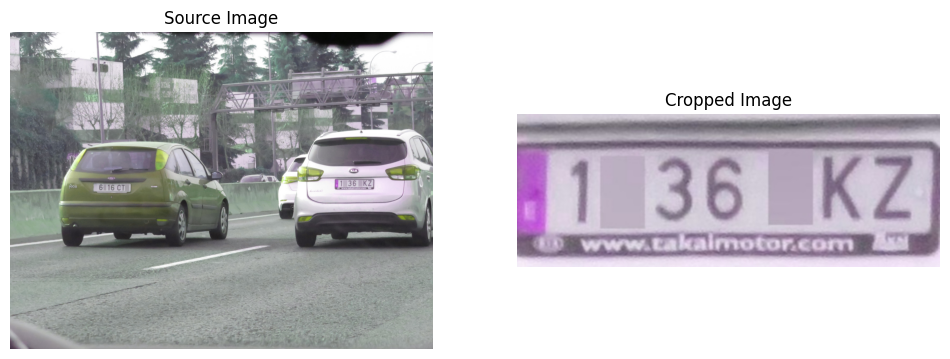

{'Text': '5i', 'Probability': 0.01655604118109581}
{'Text': '81128', 'Probability': 0.656196120058231}
{'Text': 'GZ', 'Probability': 0.3488810340919468}


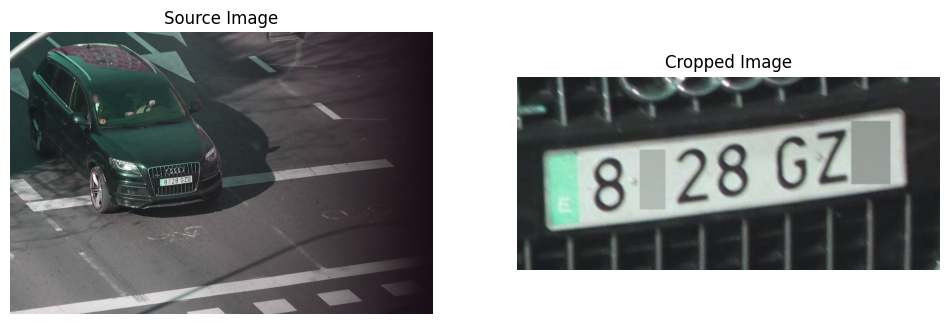

{'Text': 'GC', 'Probability': 0.9958849058232272}
{'Text': '5978', 'Probability': 0.5040209462773261}


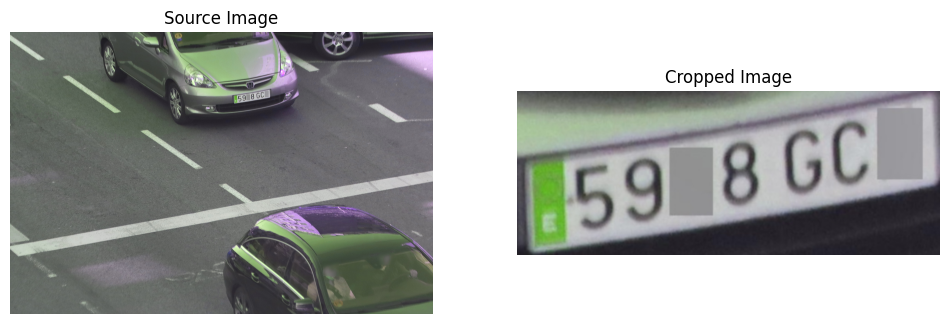

{'Text': '0a', 'Probability': 0.1244131202464956}
{'Text': 'V]', 'Probability': 0.17219802101681572}


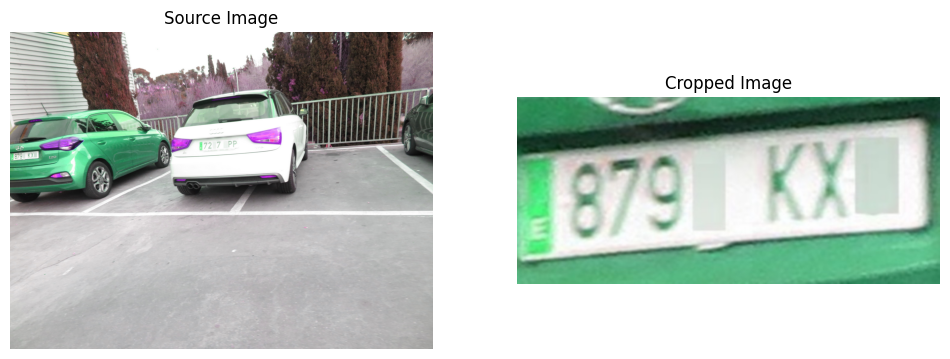

In [8]:
import random

first_dataset = source_dataset_location
second_dataset = scale_dataset_location

# start_index = 0
start_index = random.randint(0, len(os.listdir(second_dataset)))

for img_file in os.listdir(second_dataset)[start_index:start_index+10]:
    if img_file.endswith('jpg'):
        cropped_img_path = os.path.join(second_dataset, img_file)
        source_img_path = os.path.join(first_dataset, img_file[6:])
        results_path = os.path.join(results_dir, img_file[:-3]+'json')

        cropped_img = cv2.imread(cropped_img_path)
        source_img = cv2.imread(source_img_path)
        cropped_img_rgb = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
        source_img_rgb = cv2.cvtColor(source_img, cv2.COLOR_BGR2RGB)
        
        with open(results_path, 'r') as f:
            results = json.load(f)
            for result in results:
                print(result)
        
        # Plot images and results
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].imshow(source_img_rgb)
        axes[0].set_title('Source Image')
        axes[0].axis('off')
        
        axes[1].imshow(cropped_img_rgb)
        axes[1].set_title('Cropped Image')
        axes[1].axis('off')
        
        plt.show()

## 4. Evaluating OCR Results

We load the ground truth data from a CSV file.

In [9]:
df_true_location = f'{dataset_location}/output.csv'
df_true = pd.read_csv(df_true_location)
df_true['picture_name'] = df_true['picture_name'].apply(lambda x: 'plate_'+x)
df_true.set_index('picture_name', inplace=True)
df_true.head()

,text
picture_name,
plate_00808.jpg,046TS
plate_01433.jpg,912FB
plate_01063.jpg,044FF
plate_01576.jpg,M496T
plate_00263.jpg,155DW


We process the OCR results and save them in a CSV file.

In [10]:
df_pred_location = f'{output_location}/pred.csv'
plate_numbers = []
plate_strings = []

threshold = 0.6

for ocr_file in os.listdir(results_dir):
    with open(os.path.join(results_dir, ocr_file), 'r') as f:
        plt_str = ''
        results = json.load(f)
        for result in results:
            if float(result['Probability']) > threshold:
                plt_str += result['Text']
        plt_str = plt_str.replace(" ", "").upper()
        plate_strings.append(plt_str)
        plate_numbers.append(ocr_file.split('.')[0]+'.jpg')

df_pred = pd.DataFrame({'picture_name':plate_numbers, 'text':plate_strings})
df_pred.to_csv(df_pred_location)
df_pred.set_index('picture_name', inplace=True)
df_pred.head()

,text
picture_name,
plate_01772.jpg,
plate_00694.jpg,238
plate_00978.jpg,MP
plate_01461.jpg,LLY
plate_00857.jpg,0659


We evaluate the OCR performance using accuracy, Levenshtein ratio, and character-level precision, recall, and F1 score.

In [ ]:
import pandas as pd
from difflib import SequenceMatcher
from sklearn.metrics import f1_score, precision_score, recall_score

# Merging dataframes on 'picture_name' index to only evaluate overlapping entries
df_merged = df_true.join(df_pred, lsuffix='_true', rsuffix='_pred', how='inner')

# 1. Accuracy (Exact Match)
exact_matches = (df_merged['text_true'] == df_merged['text_pred']).sum()
accuracy = exact_matches / len(df_merged)

# 2. Levenshtein Distance (Edit Distance) - Using SequenceMatcher
def levenshtein_ratio(str1, str2):
    return SequenceMatcher(None, str1, str2).ratio()

df_merged['levenshtein_ratio'] = df_merged.apply(lambda row: levenshtein_ratio(row['text_true'], row['text_pred']), axis=1)
average_levenshtein_ratio = df_merged['levenshtein_ratio'].mean()

# 3. Character-Level Precision, Recall, F1 Score
def calculate_char_level_scores(true_text, pred_text):
    # Creating sets of characters for precision, recall, F1
    true_chars = set(true_text)
    pred_chars = set(pred_text)
    
    true_positive = len(true_chars & pred_chars)
    precision = true_positive / len(pred_chars) if pred_chars else 0
    recall = true_positive / len(true_chars) if true_chars else 0
    f1 = (2 * precision * recall) / (precision + recall) if precision + recall > 0 else 0
    return precision, recall, f1

# Calculate character-level scores for each entry
df_merged[['char_precision', 'char_recall', 'char_f1']] = df_merged.apply(
    lambda row: pd.Series(calculate_char_level_scores(row['text_true'], row['text_pred'])), axis=1
)

# Aggregate the results
average_precision = df_merged['char_precision'].mean()
average_recall = df_merged['char_recall'].mean()
average_f1_score = df_merged['char_f1'].mean()

# Output results
print(f"Accuracy (Exact Match): {accuracy:.2f}")
print(f"Average Levenshtein Ratio: {average_levenshtein_ratio:.2f}")
print(f"Character-Level Precision: {average_precision:.2f}")
print(f"Character-Level Recall: {average_recall:.2f}")
print(f"Character-Level F1 Score: {average_f1_score:.2f}")

df_merged_loaction = f'{output_location}/merged.csv'
df_merged.to_csv(df_merged_loaction)


Accuracy (Exact Match): 0.10
Average Levenshtein Ratio: 0.48
Character-Level Precision: 0.64
Character-Level Recall: 0.49
Character-Level F1 Score: 0.53


: 

## Conclusion
This notebook demonstrates a complete pipeline for object detection and OCR evaluation. The steps include performing object detection using YOLOv5, cropping detected objects, applying OCR using EasyOCR, and evaluating the OCR results using various metrics. The results are saved for further analysis.

